In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
#os.environ['CUDA_VISIBLE_DEVICED'] = '0,1,2'

from sklearn.metrics import classification_report, confusion_matrix

# deep learning libraries
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization
from keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.api._v2.keras.preprocessing import image
from keras.api._v2.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

#ensemble
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average

import cv2

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!kaggle competitions download -c detect-pneumonia-spring-2023

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
!unzip detect-pneumonia-spring-2023.zip

Archive:  detect-pneumonia-spring-2023.zip
replace labels_train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
train_path = "/content/train_images/train_images"
test_path = "/content/test_images/test_images"


In [ ]:
import os
os.environ['KAGGLE_USERNAME']="omirosboutsios"
os.environ['KAGGLE_KEY']="8ef56abccae1864bc255cee2fcdf436d"

In [ ]:
labels = pd.read_csv('labels_train.csv')

# Print the first few rows to check
print(labels.head())

                     file_name  class_id
0  img_4358977458434011046.jpg         1
1  img_5224016757187192130.jpg         2
2  img_3065202206106254707.jpg         2
3  img_6304894865561547174.jpg         1
4  img_3371338542810939877.jpg         2


In [ ]:
labels.head()

,file_name,class_id
0,img_4358977458434011046.jpg,1
1,img_5224016757187192130.jpg,2
2,img_3065202206106254707.jpg,2
3,img_6304894865561547174.jpg,1
4,img_3371338542810939877.jpg,2


In [ ]:
# Data agumentation and pre-processing using tensorflow

#function for adjusting contrast
def custom_augmentation(np_tensor):

  def random_contrast(np_tensor):
    return tf.image.random_contrast(np_tensor, 0.5, 2)

  augmnted_tensor = random_contrast(np_tensor)
  return np.array(augmnted_tensor)

gen = ImageDataGenerator(
    rescale=1./255.,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range = 0.2,
    #preprocessing_function=custom_augmentation,
    validation_split=0.2
                 )

train_generator = gen.flow_from_dataframe(
    labels, # dataframe
    directory = train_path, # images data path / folder in which images are there
    x_col = 'file_name',
    y_col = 'class_id',
    subset='training',
    color_mode='rgb',
    target_size = (224,224), # image height , image width
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
)


val_generator = gen.flow_from_dataframe(
    labels, # dataframe
    directory = train_path, # images data path / folder in which images are there
    x_col = 'file_name',
    y_col = 'class_id',
    subset='validation',
    color_mode='rgb',
    target_size = (224,224), # image height , image width
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
)

Found 3738 validated image filenames.
Found 934 validated image filenames.


In [ ]:
x,y = next(train_generator)
x.shape # input shape of one record is (331,331,3) , 32: is the batch size

(32, 224, 224, 3)

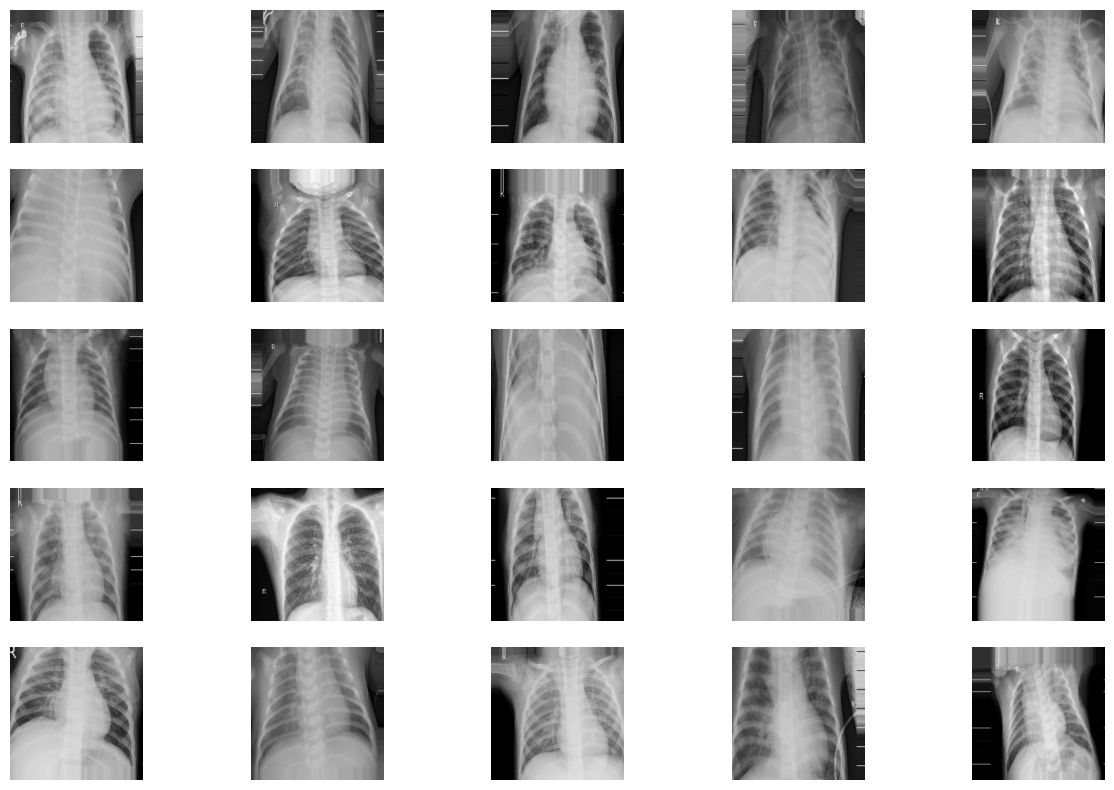

In [ ]:
#Plotting images from the train dataset
def plot_images(img, labels):
    plt.figure(figsize=[15, 10])
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(img[i])
        #plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')

plot_images(x,y)

In [ ]:
# # Dimensions of our images.
img_width, img_height = 224, 224
num_channels = 3
callbacks = EarlyStopping(monitor='val_loss', patience=40, verbose=1, mode='auto')
# Define a callback to save the model weights only when validation accuracy is maximized
checkpoint1 = ModelCheckpoint('best_model_VGG19.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
checkpoint2 = ModelCheckpoint('best_model_CNN.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

In [ ]:
# Load the VGG19 model without the top layers and with the desired input shape
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Flatten the output layer to 1 dimension
x = Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(256, activation='relu')(x)
x= BatchNormalization()(x)
x=Dropout(0.7)(x)
x= Dense(256,activation='relu')(x)
x= BatchNormalization()(x)
x=Dropout(0.7)(x)



# Add a final softmax layer for classification
output = Dense(3, activation='softmax')(x)

model1 = Model(base_model.input, output)

# Freeze the layers of the base model. This is important so that the weights of the pre-trained model remain unchanged during the initial training.
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
batch_size=32
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = val_generator.n//val_generator.batch_size

history1 = model1.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=50,
                    callbacks=[callbacks,checkpoint1])

Epoch 1/50
116/116 [==============================] - ETA: 0s - loss: 1.3515 - accuracy: 0.5693
Epoch 1: val_accuracy improved from -inf to 0.58297, saving model to best_model_VGG19.h5
116/116 [==============================] - 104s 793ms/step - loss: 1.3515 - accuracy: 0.5693 - val_loss: 1.4243 - val_accuracy: 0.5830
Epoch 2/50
116/116 [==============================] - ETA: 0s - loss: 0.9426 - accuracy: 0.6484
Epoch 2: val_accuracy improved from 0.58297 to 0.69720, saving model to best_model_VGG19.h5
116/116 [==============================] - 91s 789ms/step - loss: 0.9426 - accuracy: 0.6484 - val_loss: 0.9143 - val_accuracy: 0.6972
Epoch 3/50
116/116 [==============================] - ETA: 0s - loss: 0.8176 - accuracy: 0.6775
Epoch 3: val_accuracy did not improve from 0.69720
116/116 [==============================] - 91s 786ms/step - loss: 0.8176 - accuracy: 0.6775 - val_loss: 1.2078 - val_accuracy: 0.5776
Epoch 4/50
116/116 [==============================] - ETA: 0s - loss: 0.6931 

In [ ]:
# Unfreeze the last few layers
for layer in base_model.layers:
    layer.trainable = True

# Use SGD with momentum as the optimizer, and add a learning rate scheduler
optimizer = SGD(lr=0.0001, momentum=0.9)
lr_scheduler = ReduceLROnPlateau(factor=0.1, patience=10)

# Recompile the model with the new optimizer and learning rate scheduler
model1.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Add Batch Normalization after each Conv layer in your base model (just an example, you need to adapt this according to your actual model structure)
for i, layer in enumerate(base_model.layers):
    if isinstance(layer, Conv2D):
        base_model.layers.insert(i+1, BatchNormalization())

# Adjust your data augmentation settings
gen = ImageDataGenerator(
    rescale=1./255.,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# ...

history1 = model1.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=50,
                    callbacks = [callbacks, checkpoint1, lr_scheduler]  # Add the learning rate scheduler to the callbacks
                    )


Epoch 1/50
116/116 [==============================] - ETA: 0s - loss: 0.4803 - accuracy: 0.7914
Epoch 1: val_accuracy did not improve from 0.83836
116/116 [==============================] - 98s 806ms/step - loss: 0.4803 - accuracy: 0.7914 - val_loss: 0.4408 - val_accuracy: 0.8200 - lr: 1.0000e-04
Epoch 2/50
116/116 [==============================] - ETA: 0s - loss: 0.4445 - accuracy: 0.8135
Epoch 2: val_accuracy improved from 0.83836 to 0.84375, saving model to best_model_VGG19.h5
116/116 [==============================] - 91s 783ms/step - loss: 0.4445 - accuracy: 0.8135 - val_loss: 0.4070 - val_accuracy: 0.8438 - lr: 1.0000e-04
Epoch 3/50
116/116 [==============================] - ETA: 0s - loss: 0.4292 - accuracy: 0.8162
Epoch 3: val_accuracy did not improve from 0.84375
116/116 [==============================] - 91s 781ms/step - loss: 0.4292 - accuracy: 0.8162 - val_loss: 0.4280 - val_accuracy: 0.8200 - lr: 1.0000e-04
Epoch 4/50
116/116 [==============================] - ETA: 0s - l

In [ ]:
# Model2 architecture
model2 = Sequential()
model2.add(Conv2D(64, (3, 3), input_shape=(img_width, img_height, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(128, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(256, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# Additional Conv2D and MaxPooling2D layers
model2.add(Conv2D(512, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(1024, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten())
model2.add(Dense(512))
model2.add(Activation('relu'))
model2.add(Dropout(0.5))
model2.add(Dense(256))  # Increased neurons in dense layer
model2.add(Activation('relu'))  # Added additional Dense layer with ReLU activation
model2.add(Dropout(0.5))  # Added additional Dropout layer
model2.add(Dense(3))  # Change number based on number of classes
model2.add(Activation('softmax'))


In [ ]:
 model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 activation (Activation)     (None, 222, 222, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     73856     
                                                                 
 activation_1 (Activation)   (None, 109, 109, 128)     0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 128)      0         
 2D)                                                    

In [ ]:
# Compile the model
model2.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history2 = model2.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=50,
                    callbacks=[callbacks,checkpoint2])

Epoch 1/50
116/116 [==============================] - ETA: 0s - loss: 1.0584 - accuracy: 0.4790
Epoch 1: val_accuracy improved from -inf to 0.51293, saving model to best_model_CNN.h5
116/116 [==============================] - 96s 788ms/step - loss: 1.0584 - accuracy: 0.4790 - val_loss: 0.9844 - val_accuracy: 0.5129
Epoch 2/50
116/116 [==============================] - ETA: 0s - loss: 0.9471 - accuracy: 0.5407
Epoch 2: val_accuracy improved from 0.51293 to 0.58082, saving model to best_model_CNN.h5
116/116 [==============================] - 91s 783ms/step - loss: 0.9471 - accuracy: 0.5407 - val_loss: 0.8808 - val_accuracy: 0.5808
Epoch 3/50
116/116 [==============================] - ETA: 0s - loss: 0.8986 - accuracy: 0.5807
Epoch 3: val_accuracy improved from 0.58082 to 0.64440, saving model to best_model_CNN.h5
116/116 [==============================] - 90s 781ms/step - loss: 0.8986 - accuracy: 0.5807 - val_loss: 0.8082 - val_accuracy: 0.6444
Epoch 4/50
116/116 [=======================

In [ ]:
# Use SGD with momentum as the optimizer, and add a learning rate scheduler
optimizer = SGD(lr=0.0001, momentum=0.9)
lr_scheduler = ReduceLROnPlateau(factor=0.1, patience=10)

# Recompile the model with the new optimizer and learning rate scheduler
model2.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Adjust your data augmentation settings
gen = ImageDataGenerator(
    rescale=1./255.,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# ...

history2 = model2.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=50,
                    callbacks = [callbacks, checkpoint2, lr_scheduler]  # Add the learning rate scheduler to the callbacks
                    )

Epoch 1/50
116/116 [==============================] - ETA: 0s - loss: 0.3905 - accuracy: 0.8338
Epoch 1: val_accuracy did not improve from 0.82435
116/116 [==============================] - 91s 782ms/step - loss: 0.3905 - accuracy: 0.8338 - val_loss: 0.4648 - val_accuracy: 0.8147 - lr: 1.0000e-04
Epoch 2/50
116/116 [==============================] - ETA: 0s - loss: 0.3897 - accuracy: 0.8378
Epoch 2: val_accuracy did not improve from 0.82435
116/116 [==============================] - 89s 768ms/step - loss: 0.3897 - accuracy: 0.8378 - val_loss: 0.4426 - val_accuracy: 0.8222 - lr: 1.0000e-04
Epoch 3/50
116/116 [==============================] - ETA: 0s - loss: 0.4023 - accuracy: 0.8324
Epoch 3: val_accuracy did not improve from 0.82435
116/116 [==============================] - 89s 768ms/step - loss: 0.4023 - accuracy: 0.8324 - val_loss: 0.4787 - val_accuracy: 0.8017 - lr: 1.0000e-04
Epoch 4/50
116/116 [==============================] - ETA: 0s - loss: 0.3871 - accuracy: 0.8332
Epoch 4: v

In [ ]:
# construct ensemble model
model_1 = load_model('best_model_VGG19.h5')
model_1 = Model(inputs = model_1.inputs,
                outputs = model_1.outputs,
                name = 'name_of_model_1')
model_2 = load_model('best_model_CNN.h5')
model_1 = Model(inputs = model_2.inputs,
                outputs = model_2.outputs,
                name = 'name_of_model_2')
models = [model_1, model_2]
model_input = Input(shape=(224, 224, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

In [ ]:
#Use checkpoint for saving best ensemble model
checkpoint = ModelCheckpoint('best_model_ensemble.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

In [ ]:
#compile ensemble model
ensemble_model.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history = ensemble_model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=50,
                    callbacks = [callbacks, checkpoint]
                    )

Epoch 1/50
116/116 [==============================] - ETA: 0s - loss: 0.4119 - accuracy: 0.8260
Epoch 1: val_accuracy improved from -inf to 0.81897, saving model to best_model_ensemble.h5


116/116 [==============================] - 93s 776ms/step - loss: 0.4119 - accuracy: 0.8260 - val_loss: 0.5267 - val_accuracy: 0.8190
Epoch 2/50
116/116 [==============================] - ETA: 0s - loss: 0.4088 - accuracy: 0.8300
Epoch 2: val_accuracy did not improve from 0.81897
116/116 [==============================] - 89s 771ms/step - loss: 0.4088 - accuracy: 0.8300 - val_loss: 0.4712 - val_accuracy: 0.8136
Epoch 3/50
116/116 [==============================] - ETA: 0s - loss: 0.4097 - accuracy: 0.8362
Epoch 3: val_accuracy did not improve from 0.81897
116/116 [==============================] - 90s 773ms/step - loss: 0.4097 - accuracy: 0.8362 - val_loss: 0.5207 - val_accuracy: 0.8039
Epoch 4/50
116/116 [==============================] - ETA: 0s - loss: 0.4113 - accuracy: 0.8292
Epoch 4: val_accuracy improved from 0.81897 to 0.82220, saving model to best_model_ensemble.h5


116/116 [==============================] - 90s 777ms/step - loss: 0.4113 - accuracy: 0.8292 - val_loss: 0.4458 - val_accuracy: 0.8222
Epoch 5/50
116/116 [==============================] - ETA: 0s - loss: 0.3867 - accuracy: 0.8332
Epoch 5: val_accuracy did not improve from 0.82220
116/116 [==============================] - 90s 775ms/step - loss: 0.3867 - accuracy: 0.8332 - val_loss: 0.4751 - val_accuracy: 0.8039
Epoch 6/50
116/116 [==============================] - ETA: 0s - loss: 0.3833 - accuracy: 0.8365
Epoch 6: val_accuracy did not improve from 0.82220
116/116 [==============================] - 91s 782ms/step - loss: 0.3833 - accuracy: 0.8365 - val_loss: 0.5301 - val_accuracy: 0.8050
Epoch 7/50
116/116 [==============================] - ETA: 0s - loss: 0.3912 - accuracy: 0.8359
Epoch 7: val_accuracy did not improve from 0.82220
116/116 [==============================] - 89s 772ms/step - loss: 0.3912 - accuracy: 0.8359 - val_loss: 0.4706 - val_accuracy: 0.8125
Epoch 8/50
116/116 [===

116/116 [==============================] - 89s 771ms/step - loss: 0.3717 - accuracy: 0.8446 - val_loss: 0.4731 - val_accuracy: 0.8276
Epoch 13/50
116/116 [==============================] - ETA: 0s - loss: 0.3745 - accuracy: 0.8497
Epoch 13: val_accuracy did not improve from 0.82759
116/116 [==============================] - 89s 769ms/step - loss: 0.3745 - accuracy: 0.8497 - val_loss: 0.4764 - val_accuracy: 0.8082
Epoch 14/50
116/116 [==============================] - ETA: 0s - loss: 0.3805 - accuracy: 0.8467
Epoch 14: val_accuracy did not improve from 0.82759
116/116 [==============================] - 89s 767ms/step - loss: 0.3805 - accuracy: 0.8467 - val_loss: 0.4911 - val_accuracy: 0.8114
Epoch 15/50
116/116 [==============================] - ETA: 0s - loss: 0.3620 - accuracy: 0.8465
Epoch 15: val_accuracy did not improve from 0.82759
116/116 [==============================] - 89s 768ms/step - loss: 0.3620 - accuracy: 0.8465 - val_loss: 0.5028 - val_accuracy: 0.8190
Epoch 16/50
116/1

116/116 [==============================] - 91s 784ms/step - loss: 0.3414 - accuracy: 0.8602 - val_loss: 0.4528 - val_accuracy: 0.8362
Epoch 21/50
116/116 [==============================] - ETA: 0s - loss: 0.3389 - accuracy: 0.8654
Epoch 21: val_accuracy did not improve from 0.83621
116/116 [==============================] - 90s 780ms/step - loss: 0.3389 - accuracy: 0.8654 - val_loss: 0.4573 - val_accuracy: 0.8071
Epoch 22/50
116/116 [==============================] - ETA: 0s - loss: 0.3376 - accuracy: 0.8624
Epoch 22: val_accuracy did not improve from 0.83621
116/116 [==============================] - 90s 778ms/step - loss: 0.3376 - accuracy: 0.8624 - val_loss: 0.5360 - val_accuracy: 0.8060
Epoch 23/50
116/116 [==============================] - ETA: 0s - loss: 0.3411 - accuracy: 0.8608
Epoch 23: val_accuracy did not improve from 0.83621
116/116 [==============================] - 90s 779ms/step - loss: 0.3411 - accuracy: 0.8608 - val_loss: 0.5607 - val_accuracy: 0.8114
Epoch 24/50
116/1

116/116 [==============================] - 90s 776ms/step - loss: 0.3055 - accuracy: 0.8705 - val_loss: 0.4911 - val_accuracy: 0.8373
Epoch 38/50
116/116 [==============================] - ETA: 0s - loss: 0.3212 - accuracy: 0.8710
Epoch 38: val_accuracy did not improve from 0.83728
116/116 [==============================] - 89s 770ms/step - loss: 0.3212 - accuracy: 0.8710 - val_loss: 0.4698 - val_accuracy: 0.8050
Epoch 39/50
116/116 [==============================] - ETA: 0s - loss: 0.3138 - accuracy: 0.8691
Epoch 39: val_accuracy did not improve from 0.83728
116/116 [==============================] - 89s 770ms/step - loss: 0.3138 - accuracy: 0.8691 - val_loss: 0.5291 - val_accuracy: 0.8200
Epoch 40/50
116/116 [==============================] - ETA: 0s - loss: 0.2916 - accuracy: 0.8797
Epoch 40: val_accuracy did not improve from 0.83728
116/116 [==============================] - 90s 775ms/step - loss: 0.2916 - accuracy: 0.8797 - val_loss: 0.5236 - val_accuracy: 0.8114
Epoch 41/50
116/1

In [ ]:
# Use SGD with momentum as the optimizer, and add a learning rate scheduler
optimizer = SGD(lr=0.0001, momentum=0.9)
lr_scheduler = ReduceLROnPlateau(factor=0.1, patience=10)

# Recompile the model with the new optimizer and learning rate scheduler
ensemble_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = ensemble_model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=50,
                    callbacks = [callbacks, checkpoint, lr_scheduler]  # Add the learning rate scheduler to the callbacks
                    )

Epoch 1/50
116/116 [==============================] - ETA: 0s - loss: 0.2433 - accuracy: 0.9021
Epoch 1: val_accuracy did not improve from 0.83728
116/116 [==============================] - 91s 776ms/step - loss: 0.2433 - accuracy: 0.9021 - val_loss: 0.4885 - val_accuracy: 0.8093 - lr: 1.0000e-04
Epoch 2/50
116/116 [==============================] - ETA: 0s - loss: 0.2437 - accuracy: 0.9047
Epoch 2: val_accuracy did not improve from 0.83728
116/116 [==============================] - 90s 775ms/step - loss: 0.2437 - accuracy: 0.9047 - val_loss: 0.4730 - val_accuracy: 0.8147 - lr: 1.0000e-04
Epoch 3/50
116/116 [==============================] - ETA: 0s - loss: 0.2450 - accuracy: 0.8996
Epoch 3: val_accuracy did not improve from 0.83728
116/116 [==============================] - 89s 769ms/step - loss: 0.2450 - accuracy: 0.8996 - val_loss: 0.4994 - val_accuracy: 0.8114 - lr: 1.0000e-04
Epoch 4/50
116/116 [==============================] - ETA: 0s - loss: 0.2368 - accuracy: 0.9010
Epoch 4: v

116/116 [==============================] - 90s 780ms/step - loss: 0.2301 - accuracy: 0.9096 - val_loss: 0.5125 - val_accuracy: 0.8384 - lr: 1.0000e-06
Epoch 35/50
116/116 [==============================] - ETA: 0s - loss: 0.2170 - accuracy: 0.9091
Epoch 35: val_accuracy did not improve from 0.83836
116/116 [==============================] - 91s 784ms/step - loss: 0.2170 - accuracy: 0.9091 - val_loss: 0.5137 - val_accuracy: 0.8341 - lr: 1.0000e-06
Epoch 36/50
116/116 [==============================] - ETA: 0s - loss: 0.2193 - accuracy: 0.9118
Epoch 36: val_accuracy did not improve from 0.83836
116/116 [==============================] - 91s 787ms/step - loss: 0.2193 - accuracy: 0.9118 - val_loss: 0.5440 - val_accuracy: 0.8103 - lr: 1.0000e-06
Epoch 37/50
116/116 [==============================] - ETA: 0s - loss: 0.2200 - accuracy: 0.9104
Epoch 37: val_accuracy did not improve from 0.83836
116/116 [==============================] - 91s 782ms/step - loss: 0.2200 - accuracy: 0.9104 - val_lo

In [ ]:
# Load the trained model
model = load_model('best_model_ensemble.h5')  # replace with the path to your saved model

# Define the image dimensions (must be the same as what the model expects)
img_width, img_height = 224, 224

# Directory containing test images
test_dir = '/kaggle/input/detect-pneumonia-spring-2023/test_images/test_images'

# DataFrame to store results
results = []

# Loop over each file in the test directory
for file in os.listdir(test_dir):
    # Load the image file
    img_path = os.path.join(test_dir, file)
    img = image.load_img(img_path).convert('RGB')  # Convert to RGB
    img = img.resize((img_width, img_height), resample = 1)  # Resize the image

    # Convert the image to a numpy array and reshape it
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    # Normalize the image (if you did this for the model input)
    x /= 255.0

    # Use the model to make a prediction
    prediction = model.predict(x)
    predicted_class = np.argmax(prediction)

    # Add the filename and prediction to the results
    results.append({'file_name': file, 'class_id': predicted_class})

# Convert results to a DataFrame and save as a CSV file
results_df = pd.DataFrame(results)
results_df.to_csv('test_predictions.csv', index=False)

FileNotFoundError: ignored

In [ ]:
# store results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Ensemble')

In [ ]:
# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss Ensemble')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()